<a href="https://colab.research.google.com/github/lauranorenab/Proyecto_Modelos_2/blob/main/Extreme_Gradient_Boosting_Car_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, cohen_kappa_score, matthews_corrcoef
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.utils import check_random_state
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn import tree
import seaborn as sns
import pandas as pd
import numpy as np

# Descripción

Este colab tiene como objetivo explorar la efectividad del modelo de "Extreme Gradient Boostring" en un conjunto de datos desbalanceado y en otro balanceado con la técnica de SMOTE.

# Lectura de los datasets

## Dataset desbalanceado

In [ ]:
df_car_unbalanced = pd.read_csv("car_evaluation_unbalanced.csv")
X_unbalanced = df_car_unbalanced.iloc[:, :-1]
y_unbalanced = df_car_unbalanced.iloc[:, -1].to_numpy().reshape(len(df_car_unbalanced.iloc[:, -1]),1)

In [ ]:
X_unbalanced.shape, y_unbalanced.shape

((1728, 6), (1728, 1))

## Dataset balanceado con SMOTE

In [ ]:
df_car_smote = pd.read_csv("car_evaluation_smote.csv")
X_smote = df_car_smote.iloc[:, :-1]
y_smote = df_car_smote.iloc[:, -1].to_numpy().reshape(len(df_car_smote.iloc[:, -1]),1)

In [ ]:
X_smote.shape, y_smote.shape

((4840, 6), (4840, 1))

# Split de los datos

**Se realiza una división de los conjutos de datos, donde el 70% se usará para entrenamiento y el 30% restante para testeo**

## Dataset Desbalanceado

In [ ]:
X_unbalanced_train, X_unbalanced_test, y_unbalanced_train, y_unbalanced_test = train_test_split(X_unbalanced, y_unbalanced, test_size=0.3, random_state=10)

In [ ]:
X_unbalanced_train.shape, X_unbalanced_test.shape, y_unbalanced_train.shape, y_unbalanced_test.shape

((1209, 6), (519, 6), (1209, 1), (519, 1))

## Dataset balanceado con SMOTE

In [ ]:
X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X_smote, y_smote, test_size=0.3, random_state=10)

In [ ]:
X_smote_train.shape, X_smote_test.shape, y_smote_train.shape, y_smote_test.shape

((3388, 6), (1452, 6), (3388, 1), (1452, 1))

# Modelado y validación

## Búsqueda de mejores hiperparámetros

Con el fin de optimizar el rendimiento del modelo, se usó 'GridSearchCV' para ajustar adecuadamente los hiperpárametros del algoritmo. Para este caso, solo evaluaremos los parámetros:
* Min_child_weight
* Max_depth
* Gamma
* Subsample

In [ ]:
# Crear el modelo XGBRegressor
modelXGB = XGBClassifier()

# Se definen los posibles parametros
XGB_param = {
    'max_depth':[4,5,6],
    'min_child_weight':[4,5,6],
    'gamma':[i/10.0 for i in range(0,5)],
    'subsample':[i/10.0 for i in range(6,10)],
    }

gsearch = GridSearchCV(
    estimator = modelXGB,
    param_grid = XGB_param,
    cv=5
    )

## Entrenamiento y predicción

**Después de haber identificado los mejores hiperparámetros para el modelo, procedemos a entrenarlo utilizando tanto el conjunto de datos desbalanceado como el conjunto de datos balanceado.**

### Dataset desbalanceado

In [ ]:
label_encoder = LabelEncoder()

y_unbalanced_train = label_encoder.fit_transform(y_unbalanced_train.ravel())
y_unbalanced_test = label_encoder.transform(y_unbalanced_test.ravel())

# Entrenamiento usando los mejores hiperpárametros obtenidos
gsearch.fit(X_unbalanced_train, y_unbalanced_train.ravel())

# Se obtiene el modelo con los mejores hiperparámetros seleccionados
best_model_unbalanced = gsearch.best_estimator_

# Se realiza la predicción con los datos de test
y_unbalanced_pred = best_model_unbalanced.predict(X_unbalanced_test)

### Dataset balanceado con SMOTE

In [ ]:
label_encoder = LabelEncoder()

y_smote_train = label_encoder.fit_transform(y_smote_train.ravel())
y_smote_test = label_encoder.transform(y_smote_test.ravel())

# Entrenamiento usando los mejores hiperpárametros obtenidos
gsearch.fit(X_smote_train,y_smote_train.ravel())

# Se obtiene el modelo con los mejores hiperparámetros seleccionados
best_model_smote = gsearch.best_estimator_

# Se realiza la predicción con los datos de test
y_smote_pred = best_model_smote.predict(X_smote_test)

## Evaluación de métricas

**Para medir el desempeño del modelo, se utilizaron una variedad de métricas diferentes. Esto se hizo con el fin de tener una visión más general del comportamiento del modelo desde diferentes perspectivas, ya que cada una de las métricas seleccionadas aborda un aspecto especifico del rendimiento del modelo, lo que nos permite realizar una evaluación más completa y precisa de su capacidad predictiva.**

**Las métricas seleccionadas con las siguientes:**


*   **Accuracy:** Representa la proporción de todas las clases correctamente predichas sobre el total de predicciones realizadas para todas las clases.
*   **AUC:** Proporciona una medida de la capacidad del modelo para distingir cada una de las clases.
*   **Recall:** Representa la proporción de instancias positivas reales que fueron correctamente identificadas por el modelo.
*   **Precision:** Proporción de instancias positivas identificadas correctamente por el modelo sobre todas las instancias identificadas como positivas.
*   **F1 Score:** Media armónica de precision y recall. Proporciona una medida balanceada del rendimiento del modelo.
*   **Cohen's Kappa:** Mide la concordancia entre las predicciones del modelo y las clases reales, teniendo en cuenta la posibilidad de que las predicciones ocurran por azar.
*   **MCC:** Tiene en cuenta tanto los verdaderos positivos como los verdaderos negativos, proporcionando una medida de la calidad general del modelo.


In [ ]:
def show_bar_graphic(valores):
  metricas = ['Accuracy', 'AUC', 'Recall', 'Precision', 'F1 Score', "Cohen's Kappa", 'MCC']

  # Crear un gráfico de barras
  plt.figure(figsize=(10, 6))
  sns.barplot(x=metricas, y=valores, hue=metricas, palette='viridis', legend=False)
  plt.title('Métricas de Evaluación')
  plt.xlabel('Métrica')
  plt.ylabel('Valor')
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

In [ ]:
def show_spider_graph(valores):
  metricas = ['Accuracy', 'AUC', 'Recall', 'Precision', 'F1 Score', "Cohen's Kappa", 'MCC']

  # Crear un gráfico de radar
  angulos = np.linspace(0, 2*np.pi, len(metricas), endpoint=False).tolist()
  val_aux = valores.copy()
  val_aux += val_aux[:1]
  angulos += angulos[:1]

  fig, ax = plt.subplots(figsize=(4, 4), subplot_kw=dict(polar=True))
  plt.title('Métricas de Evaluación', size=20, y=1.1)
  ax.fill(angulos, val_aux, color='skyblue', alpha=0.6)
  ax.plot(angulos, val_aux, color='blue', linewidth=1)
  ax.set_yticklabels([])
  ax.set_xticks(angulos[:-1])
  ax.set_xticklabels(metricas, size=8)
  plt.show()

In [ ]:
def show_table(valores):
  metricas = ['Accuracy', 'AUC', 'Recall', 'Precision', 'F1 Score', "Cohen's Kappa", 'MCC']
  df_metricas = pd.DataFrame({'Métrica': metricas, 'Valor': valores})

  return df_metricas

### Dataset desbalanceado

In [ ]:
accuracy_unbalanced = accuracy_score(y_unbalanced_test, y_unbalanced_pred)

precision_unbalanced = precision_score(y_unbalanced_test, y_unbalanced_pred, average='weighted')

y_pred_proba_un = best_model_unbalanced.predict_proba(X_unbalanced_test)
auc_unbalanced = roc_auc_score(y_unbalanced_test.tolist(), y_pred_proba_un.tolist(), multi_class='ovr')

recall_unbalanced = recall_score(y_unbalanced_test, y_unbalanced_pred, average='weighted')

f1_unbalanced = f1_score(y_unbalanced_test, y_unbalanced_pred, average='weighted')

mcc_unbalanced = matthews_corrcoef(y_unbalanced_test, y_unbalanced_pred)

kappa_unbalanced = cohen_kappa_score(y_unbalanced_test, y_unbalanced_pred)

In [ ]:
valores_unbalanced = [accuracy_unbalanced, auc_unbalanced, recall_unbalanced, precision_unbalanced, f1_unbalanced, kappa_unbalanced, mcc_unbalanced]

In [ ]:
show_table(valores_unbalanced)

,Métrica,Valor
0,Accuracy,0.994220
1,AUC,0.999786
2,Recall,0.994220
3,Precision,0.994942
4,F1 Score,0.994369
5,Cohen's Kappa,0.987078
6,MCC,0.987154


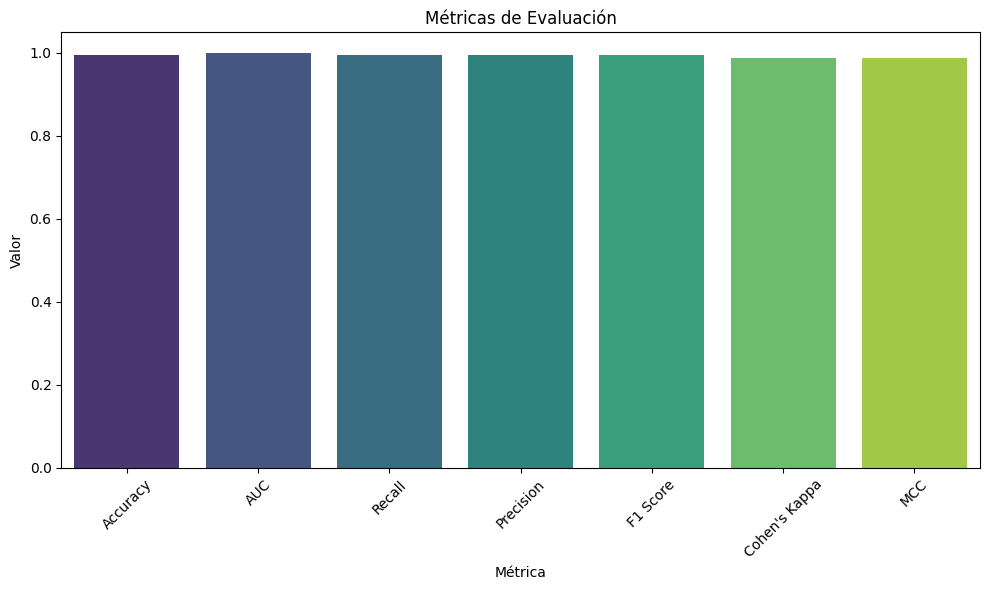

In [ ]:
show_bar_graphic(valores_unbalanced)

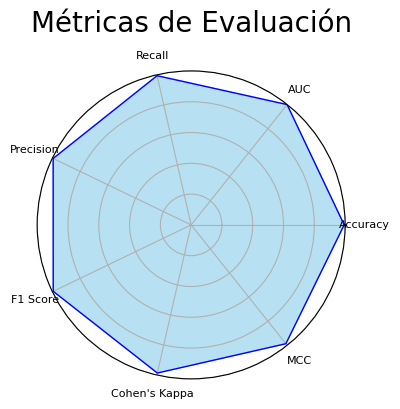

In [ ]:
show_spider_graph(valores_unbalanced)

**Conclusión:**
 Los resultados obtenidos muestran que el modelo Extreme Gradient Boosting tiene un rendimiento bastante alto en la clasificación de un dataset desbalanceado.
 * Accuracy del 99.42% indicando una precisión sobresaliente en la clasificación de todas las clases.
 * El AUC del 99.98% nos indica una muy buena capacidad para distingir entre clases.
 * El recall y precision del 99.42% y 99.49% respectivamente, muestran una sólida capacidad para identificar y clasificar correctamente las clases positivas.
 * El F1 Score del 99.44% sugiere un equilibrio alto entre precision y recall,
 * Cohen's Kappa y MCC, ambos alrededor del 98.71% y 98.72% respectivamente, reflejan una alta concordancia entre las predicciones del modelo y las clases reales.

### Dataset balanceado con SMOTE

In [ ]:
accuracy_smote = accuracy_score(y_smote_test, y_smote_pred)

precision_smote = precision_score(y_smote_test, y_smote_pred, average='weighted')

y_pred_proba_smote = best_model_smote.predict_proba(X_smote_test)
auc_smote = roc_auc_score(y_smote_test.tolist(), y_pred_proba_smote.tolist(), multi_class='ovr')

recall_smote = recall_score(y_smote_test, y_smote_pred, average='weighted')

f1_smote = f1_score(y_smote_test, y_smote_pred, average='weighted')

mcc_smote = matthews_corrcoef(y_smote_test, y_smote_pred)

kappa_smote = cohen_kappa_score(y_smote_test, y_smote_pred)

In [ ]:
valores_smote = [accuracy_smote, auc_smote, recall_smote, precision_smote, f1_smote, kappa_smote, mcc_smote]

In [ ]:
show_table(valores_smote)

,Métrica,Valor
0,Accuracy,0.994490
1,AUC,0.999976
2,Recall,0.994490
3,Precision,0.994519
4,F1 Score,0.994489
5,Cohen's Kappa,0.992652
6,MCC,0.992663


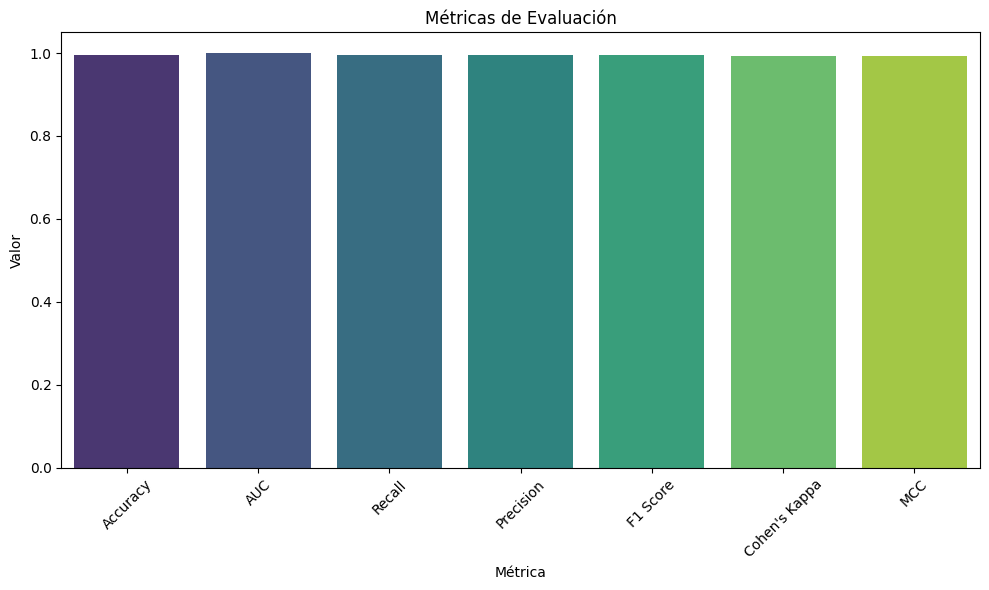

In [ ]:
show_bar_graphic(valores_smote)

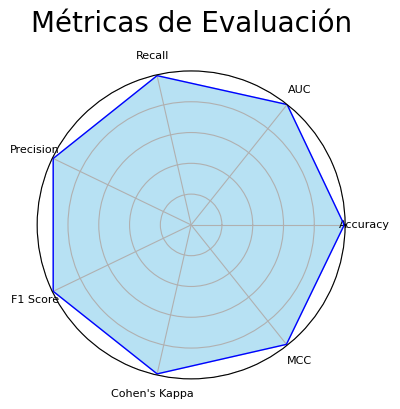

In [ ]:
show_spider_graph(valores_smote)

**Conclusión:**
 Los resultados obtenidos muestran que el modelo Extreme Gradient Boosting tiene un rendimiento bastante alto en la clasificación de un dataset desbalanceado.
 * Accuracy del 99.44% indicando una precisión sobresaliente en la clasificación de todas las clases.
 * El AUC del 99.99% nos indica una muy buena capacidad para distingir entre clases.
 * El recall y precision del 99.44% y 99.45% respectivamente, muestran una sólida capacidad para identificar y clasificar correctamente las clases positivas.
 * El F1 Score del 99.44% sugiere un equilibrio alto entre precision y recall,
 * Cohen's Kappa y MCC, ambos alrededor del 99.26%, reflejan una alta concordancia entre las predicciones del modelo y las clases reales.

# Elección del mejor modelo

In [ ]:
metricas = ['Accuracy', 'AUC', 'Recall', 'Precision', 'F1 Score', "Cohen's Kappa", 'MCC']

dataset_metrics = pd.DataFrame({'Métrica': metricas, 'Dataset desbalanceado': valores_unbalanced, 'Dataset balanceado': valores_smote})

dataset_metrics

,Métrica,Dataset desbalanceado,Dataset balanceado
0,Accuracy,0.994220,0.994490
1,AUC,0.999786,0.999976
2,Recall,0.994220,0.994490
3,Precision,0.994942,0.994519
4,F1 Score,0.994369,0.994489
5,Cohen's Kappa,0.987078,0.992652
6,MCC,0.987154,0.992663


## Curvas de aprendizaje

In [ ]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(8, 5))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Accuracy")

    # Configura la métrica de precisión
    accuracy_scorer = make_scorer(accuracy_score)

    train_sizes, train_scores, test_scores = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, scoring=accuracy_scorer)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                      train_scores_mean + train_scores_std, alpha=0.1,
                      color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                      test_scores_mean + test_scores_std, alpha=0.1,
                      color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
              label="Training Accuracy")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
              label="Cross-validation Accuracy")
    axes.legend(loc="best")

    return plt

**Curva de aprendizaje para el modelo entrenado con el dataset desbalanceado**

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

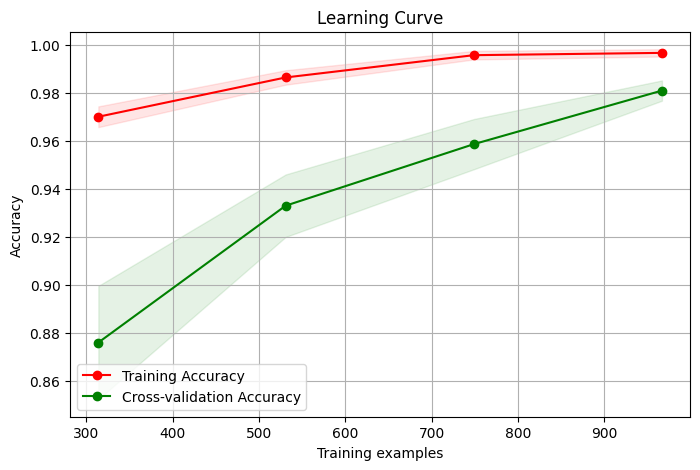

In [ ]:
plot_learning_curve(best_model_unbalanced, "Learning Curve", X_unbalanced_train, y_unbalanced_train, cv=5, n_jobs=2)

**Curva de aprendizaje para el modelo entrenado con el dataset balanceado con SMOTE**

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

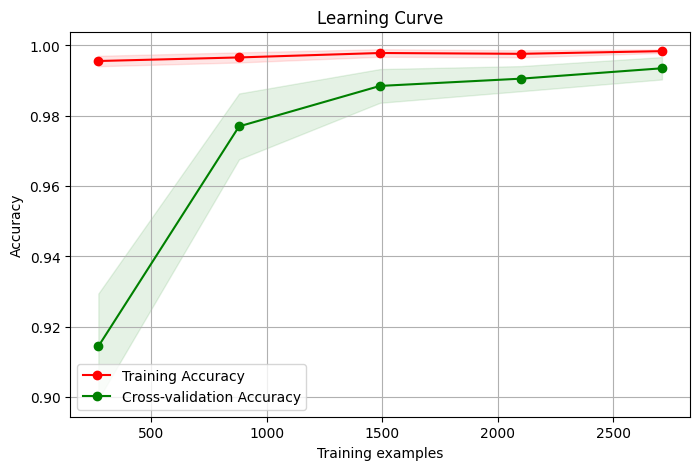

In [ ]:
plot_learning_curve(best_model_smote, "Learning Curve", X_smote_train, y_smote_train, cv=5, n_jobs=2)

## **Conclusión**
El modelo entrenado con el dataset balanceado podría considerarse ligeramente superior en términos de concordancia y relación con las clases reales. Por otro lado, esta diferencia es tan pequeña que podríamos considerar que ambos modelos tienen el mismo rendimiento y resultados. Teniendo esto en cuenta esto, optamos por elegir el modelo entrenado con el dataset balanceado debido a la sensibilidad que presentan algunas métricas a los datos desbalanceado, y si bien el Extreme Gradient Boosting es bastante robusto con este tipo de datos, consideramos que la presencia de este riesgo disminuye la confianza en el modelo desbalanceado.